# Satellite Data Acquisition - Quick Start: DEM Download (COP30DEM)

Simple example to download Copernicus DEM 30m elevation data.

Note: DEM is static elevation data - no time series or cloud coverage!

Author: Peter Kongstad

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box, Point

from sat_data_acquisition import SatDataClient, ProcessingParams, SaveParams, configure_logging
from sat_data_acquisition.processing import save_data
from sat_data_acquisition.config.settings import SatDataSettings

In [3]:
# Configure logging
configure_logging(verbose=False)

## Define Area of Interest

Create a bounding box around Copenhagen.

In [4]:
# Define area as bounding box (rectangular shape)
copenhagen_center = Point(12.5683, 55.6761)  # lon, lat
buffer = 0.024  # ~5 km

geometry = box(
    copenhagen_center.x - buffer,
    copenhagen_center.y - buffer,
    copenhagen_center.x + buffer,
    copenhagen_center.y + buffer
)

print(f"Area bounds: {geometry.bounds}")
print(f"Approximate area: {(buffer * 111 * 2)**2:.1f} km²")

Area bounds: (12.544300000000002, 55.6521, 12.5923, 55.7001)
Approximate area: 28.4 km²


## Download DEM

Download Copernicus DEM 30m elevation data. No dates or cloud coverage needed!

In [5]:
# Initialize client
client = SatDataClient()

# Configure processing parameters (no dates or cloud_coverage for DEM)
processing_params = ProcessingParams(
    satellite='CopDEM30MPC',
    search_method='geometry',
    bands=['data'],  # DEM data band
    clip_method='geometry'
)

# Note: start_date, end_date, and cloud_coverage are automatically ignored for DEM

# Search and download
dataset = client.search_and_create_image(
    geometry=geometry,
    processing_params=processing_params,
    area_name='copenhagen'
)

print(f"DEM downloaded")
print(f"Image shape: {dataset.dims}")

DEM downloaded
Image shape: FrozenMappingWarningOnValuesAccess({'latitude': 173, 'longitude': 115, 'time': 1})


## Visualize Elevation

Display the elevation data with a terrain colormap.

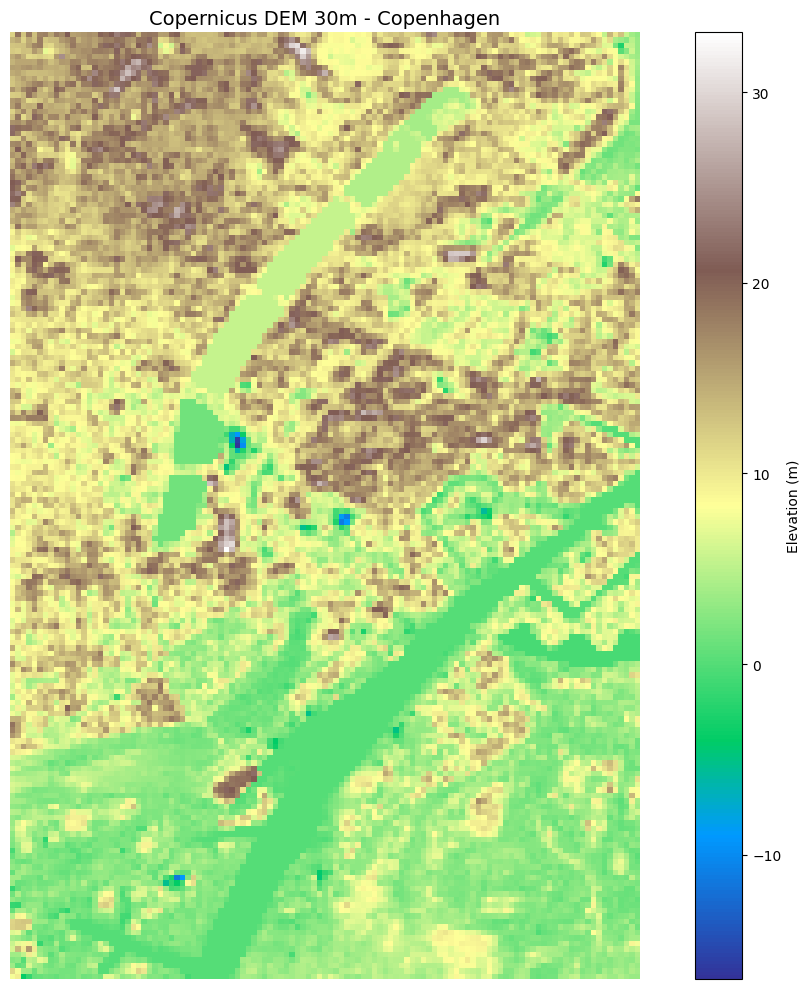


Elevation Statistics:
  Min: -16.5 m
  Max: 33.1 m
  Mean: 8.4 m
  Std: 5.8 m


In [6]:
# Extract elevation data
# DEM may or may not have time dimension - handle both cases
if 'time' in dataset.dims and len(dataset.time) > 0:
    elevation = dataset.sel(time=dataset.time.values[0])['data'].values
else:
    elevation = dataset['data'].values

# Plot with terrain colormap
plt.figure(figsize=(12, 10))
im = plt.imshow(elevation, cmap='terrain')
plt.colorbar(im, label='Elevation (m)', fraction=0.046)
plt.title('Copernicus DEM 30m - Copenhagen', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

# Print elevation statistics
print(f"\nElevation Statistics:")
print(f"  Min: {np.nanmin(elevation):.1f} m")
print(f"  Max: {np.nanmax(elevation):.1f} m")
print(f"  Mean: {np.nanmean(elevation):.1f} m")
print(f"  Std: {np.nanstd(elevation):.1f} m")

## Save to GeoTIFF

Save the DEM to a GeoTIFF file.

In [7]:
# Configure save parameters
save_params = SaveParams(
    output_path='../data',
    save_to_local=True,
    save_as_geotiff=True,
)

if 'time' in dataset.dims and len(dataset.time) > 0:
    image_slice = dataset.sel(time=dataset.time.values[0])
    date_str = str(dataset.time.values[0])[:10]
    
    save_data(
        image=image_slice,
        identifier="copenhagen",
        datetime=date_str,
        satellite=processing_params.satellite,
        provider="MPC",
        save_params=save_params,
        band="elevation",
    )
    
    print(f"Image saved to: ../data/CopDEM30MPC/{date_str[:4]}/tiff/")
    print(f"Filename: CopDEM30MPC_{date_str}_elevation_copenhagen.tif")

Image saved to: ../data/CopDEM30MPC/2021/tiff/
Filename: CopDEM30MPC_2021-04-22_elevation_copenhagen.tif


## Next Steps

- Try the [multi_area_download.ipynb](multi_area_download.ipynb) example for multiple areas
- Calculate slope and aspect from elevation
- Combine DEM with optical imagery for 3D visualization
- Use for terrain analysis, watershed delineation, viewshed analysis
- See [../README.md](../README.md) for more advanced features

## DEM Applications

- **Topographic mapping**: Contour lines, slope maps
- **Hydrological modeling**: Watershed boundaries, flow direction
- **Visibility analysis**: Line-of-sight, viewshed
- **3D visualization**: Combine with satellite imagery
- **Volume calculations**: Cut/fill analysis